Title: 2. Title Generation - Exploring the Data
Tags: preparing_data
Authors: Ben Hoyle
Summary: This post explores the data for our title generation experiments.

# 2. Title Generation - Exploring the Data

In the previous post we looked at the problem for our current project: how to generate a patent title based on our claim text.

In this post we will look at the steps required to prepare some data for our machine learning algorithms. We will also look at the nature of the data, which may give us some insights as to how we transform our data in later stages.

---
## Select Data

I have a Mongo Database with data from a set of G06 US Patent Publications. On my system 10000 data samples take up around 16MB (16724852 bytes). It thus seems possible to start with a dataset of 30000 samples. I have used this to generate a pickle file with the data that may be downloaded. 

In [3]:
import pickle
import os

PIK = "claim_and_title.data"

if not os.path.isfile(PIK):
    # Download file
    !wget https://benhoyle.github.io/notebooks/title_generation/claim_and_title.data

with open(PIK, "rb") as f:
    print("Loading data")
    data = pickle.load(f)
    print("{0} samples loaded".format(len(data)))
                                      
print("An example title:", data[0][1])
print("----")
print("An example claim:", data[0][0])

Loading data
30000 samples loaded
An example title: System and method for session restoration at geo-redundant gateways
----
An example claim: 
1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reattach to the network, wherein each DDN causes the MME to send

---

## 2. Exploring the Data

The code above generates a list of data samples of the form `(claim1_text, title)`, where `claim1_text` is a string representing the text of claim 1 and `title` is a string representing the title text.

First we can double check there are no cancelled claims.

In [4]:
# Check for and remove 'cancelled' claims
data = [d for d in data if '(canceled)' not in d[0]]

print("There are now {0} claims after filtering out cancelled claims".format(len(data)))

There are now 30000 claims after filtering out cancelled claims


In [5]:
length = max([len(d[0]) for d in data])
print("Our longest claim is {0} characters long.".format(length))

length = max([len(d[1]) for d in data])
print("Our longest title is {0} characters long.".format(length))

Our longest claim is 15887 characters long.
Our longest title is 484 characters long.


At the moment our data is in the form of a string. This is represented as a sequence of characters. When building our models we can choose to work at either the character or word level. 

Working at the character level has an advantage of operating in a lower dimensionality space (typically we have 26 lower case characters plus some punctuation - so around 30 different symbols). Also we can take our string as is. However, character level models take much longer to train, and are more likely to produce unrecognisable strings. In the "character" case, our model needs to learn what "words" are as part of its training!

Working at the word level increases our dimensionality by orders of magnitude (typically to a size of a vocabulary, which can be 10s or 100s of thousands of words). However, our model may be quicker to train, and may produce more recognisable output. 

Words require an additional pre-processing step: tokenisation. This splits our string into word tokens. There are several options for tokenisation, including:

* the [Tokenizer](https://keras.io/preprocessing/text/#tokenizer) text utility class in Keras;
* [spaCy](https://spacy.io/); or
* an [NLTK word tokeniser](http://www.nltk.org/book/ch03.html) plus a custom word-to-integer conversion.

I have found that spaCy has a better word tokenisation accuracy and is easier to integrate with other data such as part-of-speech and dependency parse information. It is slower though for large datasets. The NLTK tokeniser is faster, but requires a custom function to map words to integers.

The Keras tokenizer is fast but rather naive - it appears to simply split based on spaces.

### Basic Tokenization

One plan is to start with the Keras tokenizer and then look to change the tokenization strategy once we have a baseline model.

We will first look at some statistics regarding the text. This can inform parameters such as our vocabulary cut-off value.

In [7]:
from keras.preprocessing import text
t_claim = text.Tokenizer(
                num_words=None, 
                filters='1.:;\n',
                lower=True,
                split=" ",
                char_level=False,
                oov_token="<UNK>"
)
X_texts = [d[0] for d in data]
t_claim.fit_on_texts(X_texts)
X_seqs = t_claim.texts_to_sequences(X_texts)

In [8]:
t_title = text.Tokenizer( 
                num_words=None,
                lower=True,
                char_level=False,
                oov_token="<UNK>"
)
Y_texts = [d[1] for d in data]
t_title.fit_on_texts(Y_texts)
Y_seqs = t_title.texts_to_sequences(Y_texts)

In [9]:
print("Our input sequences (claims) have a vocabulary of {0} words".format(max([v for k, v in t_claim.word_index.items()])))
print("Our output sequences (titles) have a vocabulary of {0} words".format(max([v for k, v in t_title.word_index.items()])))

Our input sequences (claims) have a vocabulary of 53390 words
Our output sequences (titles) have a vocabulary of 11078 words


In [10]:
print(X_texts[0], X_seqs[0])


1. A method for managing a backup service gateway (SGW) associated with a primary SGW, the method comprising:
periodically receiving from the primary SGW at least a portion of corresponding UE session state information, the received portion of session state information being sufficient to enable the backup SGW to indicate to an inquiring management entity that UEs having an active session supported by the primary SGW are in a live state; and
in response to a failure of the primary SGW, the backup SGW assuming management of IP addresses and paths associated with said primary SGW and transmitting a Downlink Data Notification (DDN) toward a Mobility Management Entity (MME) for each of said UEs having an active session supported by the failed primary SGW to detach from the network and reattach to the network, wherein each DDN causes the MME to send a detach request with a reattach request code to the respective UE.

 [2, 33, 9, 583, 2, 552, 95, 1214, 34040, 37, 20, 2, 359, 26583, 1, 33, 2

In [11]:
print(Y_texts[0], Y_seqs[0])

System and method for session restoration at geo-redundant gateways [4, 1, 3, 2, 381, 1181, 164, 3020, 773, 3307]


#### Claim Length

Our longest sequence is 2310 tokens long.


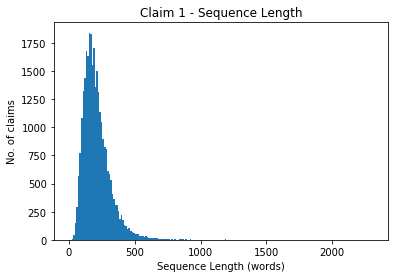

In [12]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

X_length = [len(x) for x in X_seqs]
max_length = max(X_length)
print("Our longest sequence is {0} tokens long.".format(max_length))

bins = np.linspace(0, max_length, 200)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims')
plt.xlabel('Sequence Length (words)')

So even though our maximum claim length is 2310 words, we see this maximum length is a clear outlier. The mass of our claim length distribution resides between 0 and 500 words. Let's zoom in on that.

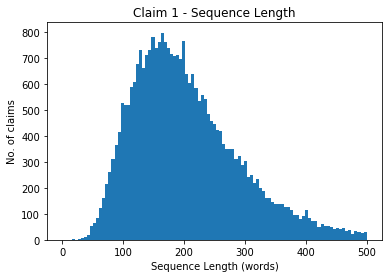

In [14]:
# Let's zoom in on 0 to 500
bins = np.linspace(0, 500, 100)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims')
plt.xlabel('Sequence Length (words)')
plt.show()

Interestingly the distribution of claim lengths seems to be log-normal. This matches the distributions described in this [blogpost on computer program line lengths](https://jakevdp.github.io/blog/2017/11/09/exploring-line-lengths-in-python-packages/). Funny how both code and patent claims have a similar distribution for sequence length. 

This is something to remember when thinking about later generative models and regularisation: a "good" generative model should replicate this log-normal distribution.

#### Title Length

Our longest sequence is 77 tokens long.


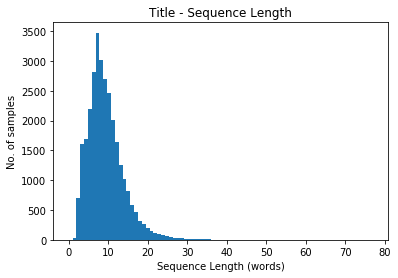

In [18]:
Y_length = [len(y) for y in Y_seqs]
max_y_length = max(Y_length)
print("Our longest sequence is {0} tokens long.".format(max_y_length))

bins = np.linspace(0, max_y_length, 80)
plt.hist(Y_length, bins)
plt.title('Title - Sequence Length')
plt.ylabel('No. of samples')
plt.xlabel('Sequence Length (words)')
plt.show()

Again 77 words seems a clear outlier. Let's zoom in on 0 to 30 where most of the distribution lies.

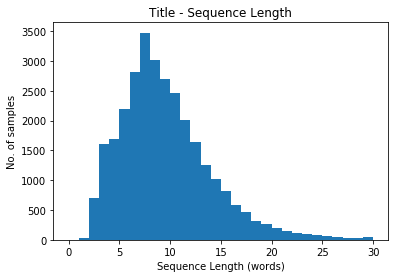

In [19]:
bins = np.linspace(0, 30, 31)
plt.hist(Y_length, bins)
plt.title('Title - Sequence Length')
plt.ylabel('No. of samples')
plt.xlabel('Sequence Length (words)')
plt.show()

Here we could probably limit our output length to 15-20 while still capturing most of the data. The modal length is around 7.

Again we appear to have a log-normal distribution.

### Dimensionality Issues

This exploration of the data raises some issues for our initial models. We have high dimensionality on two fronts: 

1. Our vocabularies are respectively ~50k and ~10k. For cross-entropy using one-hot vectors, this would require vectors of ~50k and ~10k in length. This would not only be slow to train but could lead us to run out of memory. Most "toy" problems have a maximum vocabulary of around 5000 words.
2. Most sequence-to-sequence models operate on fixed-length vectors. These are typically set based on a maximum sequence length. If a sequence is below the maximum sequence length the vector is normally zero-padded, i.e. zeros are added to fill up any missing elements in the sequence. Our maximum sequence lengths are 2310 and 77 - but most of our data is much shorter, e.g. below 500 and 30 elements.

It seems sensible to perform some filtering to address 2. Let's see how many samples we are left with if we limit our sequences to different lengths.

In [20]:
limits = [100, 200, 250, 300, 400, 500]
count = dict() 
for limit in limits:
    count[limit] = 0
    for x in X_seqs:
        if len(x) < limit:
            count[limit] += 1
    print("With limit {0} there are {1} samples".format(limit, count[limit]))

With limit 100 there are 2424 samples
With limit 200 there are 16171 samples
With limit 250 there are 21753 samples
With limit 300 there are 25307 samples
With limit 400 there are 28462 samples
With limit 500 there are 29421 samples


In [21]:
limits = [10, 15, 20, 30, 40, 50]
count = dict() 
for limit in limits:
    count[limit] = 0
    for y in Y_seqs:
        if len(y) < limit:
            count[limit] += 1
    print("With limit {0} there are {1} samples".format(limit, count[limit]))

With limit 10 there are 18199 samples
With limit 15 there are 26598 samples
With limit 20 there are 29051 samples
With limit 30 there are 29901 samples
With limit 40 there are 29984 samples
With limit 50 there are 29993 samples


In [24]:
filtered_seqs = [(x, y) for x,y in zip(X_seqs, Y_seqs) if len(x) < 300 and len(y) < 20]
len(filtered_seqs)

24575

In [25]:
filtered_seqs[0]

([2,
  33,
  9,
  583,
  2,
  552,
  95,
  1214,
  34040,
  37,
  20,
  2,
  359,
  26583,
  1,
  33,
  25,
  1959,
  56,
  19,
  1,
  359,
  16009,
  14,
  24,
  2,
  70,
  3,
  49,
  4109,
  360,
  118,
  242,
  1,
  86,
  70,
  3,
  360,
  118,
  27,
  46,
  2321,
  4,
  755,
  1,
  552,
  16009,
  4,
  940,
  4,
  11,
  6683,
  160,
  273,
  23,
  14826,
  58,
  11,
  497,
  360,
  1544,
  15,
  1,
  359,
  16009,
  48,
  6,
  2,
  1852,
  118,
  5,
  6,
  68,
  4,
  2,
  970,
  3,
  1,
  359,
  26583,
  1,
  552,
  16009,
  7142,
  160,
  3,
  685,
  732,
  5,
  1053,
  37,
  20,
  16,
  359,
  16009,
  5,
  270,
  2,
  6913,
  10,
  481,
  34041,
  1601,
  2,
  5537,
  160,
  273,
  19599,
  9,
  28,
  3,
  16,
  14826,
  58,
  11,
  497,
  360,
  1544,
  15,
  1,
  2428,
  359,
  16009,
  4,
  16010,
  19,
  1,
  60,
  5,
  26584,
  4,
  1,
  302,
  17,
  28,
  34042,
  898,
  1,
  14827,
  4,
  733,
  2,
  16010,
  62,
  20,
  2,
  26584,
  62,
  98,
  4,
  1,
  100,
  4109],
 

We lose ~5000 examples if we limit our sequence lengths to 300 and 20 respectively. This seems a good trade-off.

On the vocabulary side we also have a number of options.

* As a first approach we can simply limit our vocabulary, e.g. by only using the top V words and setting everything else to UNK.
* We can use a large vocabulary but with a hierarchical or differentiated softmax. This article [here](http://ruder.io/word-embeddings-softmax/) by Sebastian Ruder explains some of the options. Differentiated softmax is recommended [here](http://www.aclweb.org/anthology/P16-1186). However, there is no native keras implementation for this - meaning we need to get into custom models in Tensorflow. This may be outside the scope of the current project.
* We could switch to using character-level input on either the output or for both sequences.
* We could look at hybrid approaches that use word portions. Again, this may be out of the scope of this project.

To start let's limit our vocabulary to 5000 words on the input and 2500 words on the output. Later we can try to look at the effect of doubling this.

## Label Data

To enable us to work with sequence-to-sequence models, it can help to add START and STOP tokens to our output title sequences. These need to be unique tokens that are not used in our vocabulary and that are not filtered out by the text tokenizer. These could be "startseq" and "endseq".

## Format Data

Initially we will implement a word level sequence-to-sequence model as set out in this [blog post](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) (see the bonus FAQ at the bottom for a word-level example). 

This requires the following data structures:

* encoder_input_data is a 2D array of shape (num_samples, max_claim_length) 
* decoder_input_data is a 2D array of shape (num_samples, max_title_length) 
* decoder_target_data is a 3D array of shape (num_samples, max_title_length, title_vocab_length) containing one-hot encodings of the word index integers that is shifted by one timestep (i.e. by one word into the future to provide the next word)

We also need to set the following parameters:

* max_claim_length (based on our analysis above we can filter to limit to 300 words)
* max_title_length (based on our analysis above we can filter to limit to 20 words)
* num_encoder_tokens = claim_vocab_length (based on our analysis above we can start at 5000 but later explore expanding)
* num_decoder_tokens = title_vocab_length (based on our analysis above we can start at 2500 but later explore expanding)
* batch_size (the example sets this to 64 - it could be 16, 32 or 64 to start)
* epochs (the example sets this to 100 - we may initially reduce this to look at performance)

In the next post we will use this information to start building our model.